In [139]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.14.0
Pandas Version: 2.0.3
Numpy Version: 1.24.3
System Version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


## Lectura de la base de datos original

In [3]:
import os
os.chdir("C:\\Users\\LENOVO\\Desktop\\Universidad")

In [4]:
datos = pd.read_csv("datos.csv") # Cargar la base de datos
print(datos)

          IPC       Fecha
0    4.231785  2009-01-31
1    4.239887  2009-02-28
2    4.245061  2009-03-31
3    4.247352  2009-04-30
4    4.246779  2009-05-31
..        ...         ...
173  4.930654  2023-06-30
174  4.935912  2023-07-31
175  4.944068  2023-08-31
176  4.950248  2023-09-30
177  4.953147  2023-10-31

[178 rows x 2 columns]


## Gráfico de la serie de tiempo

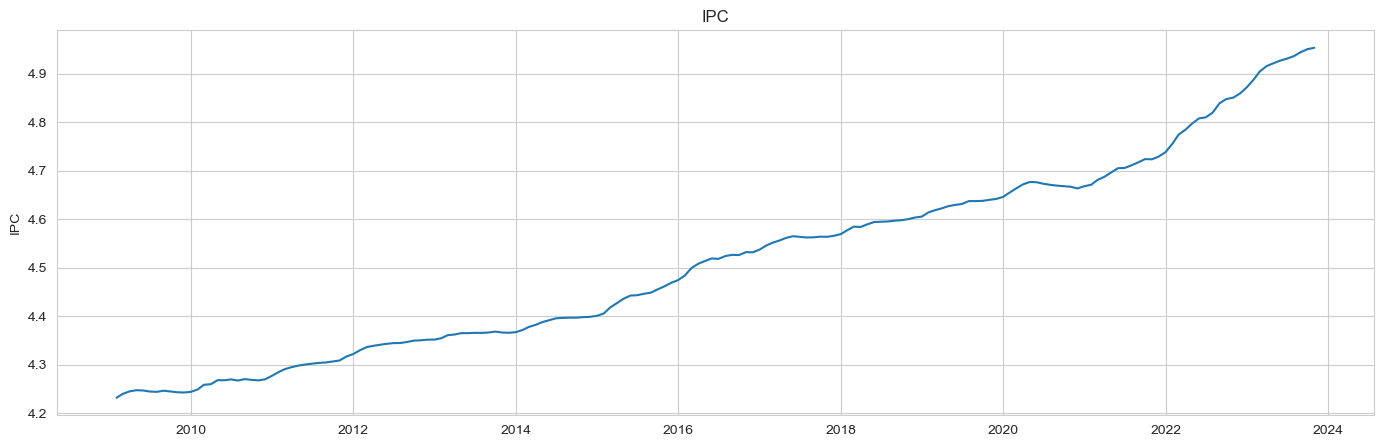

In [5]:
## Datos originales, sin transformar por box cox y sin eliminar la tendencia.
datos['Fecha']=pd.to_datetime(datos['Fecha']) # pasar a formato fecha
Valores_datos=datos.set_index('Fecha') # nuevo dataframe indexado por la fecha
Valores_datos['IPC'] = pd.to_numeric(Valores_datos['IPC'], errors='coerce')
datos_ts=Valores_datos['IPC'] # vector con los valores de la serie

plt.plot(datos_ts)
plt.title('IPC')
plt.ylabel('IPC')
plt.show()

In [74]:
features_considered2 = ['IPC']

In [75]:
features2 = Valores_datos[features_considered2]
features2.index = Valores_datos.index
features2.head()

,IPC
Fecha,
2009-01-31,4.231785
2009-02-28,4.239887
2009-03-31,4.245061
2009-04-30,4.247352
2009-05-31,4.246779


## Separación de los datos en entrenamiento, validación y prueba

In [76]:
### Separación de los datos en entrenamiento, validación y prueba
column_indices = {name: i for i, name in enumerate(features2.columns)}##Cambie el features por features2

n = len(features2)
train_df = features2[0:124]
val_df = features2[124:159]
test_df = features2[159:]

num_features = features2.shape[1]

## Normalización de los datos

In [77]:
## Normalización de los datos.
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [78]:
train_df

,IPC
Fecha,
2009-01-31,-1.463421
2009-02-28,-1.396828
2009-03-31,-1.354301
2009-04-30,-1.335470
2009-05-31,-1.340174
...,...
2018-12-31,1.605628
2019-01-31,1.679273
2019-02-28,1.713416


In [79]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (124, 1)
longitud dataframe validación: (35, 1)
longitud dataframe prueba: (19, 1)


## Función WindowGenerator.

In [80]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## split

In [81]:
def split_window(self, features2):### Aqui cambie features2 a features
  inputs = features2[:, self.input_slice, :]
  labels = features2[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Objetos a TensorFlow

In [82]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [83]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Definir las gráficas

In [84]:
def plot(self, model=None, plot_col='Impuestos', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Impuestos')

WindowGenerator.plot = plot

In [85]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Creación de la ventana

In [86]:
## Creación de la ventana que se va a utilizar en el modelamiento de las series mutlicapa y las series recurrentes
single_step_window = WindowGenerator(
    input_width=12, label_width=1, shift=2, # Tomar en cuenta 12 retardos para hacer 1 predicción 2 pasos adelante
    label_columns=['IPC'])# La variable a predecir es IPC
single_step_window

Total window size: 14
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [13]
Label column name(s): ['IPC']

In [114]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

In [88]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch
    

print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (32, 12, 1)
Target shape: (32, 1, 1)


In [89]:
for batch in single_step_window.val.take(2):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (22, 12, 1)
Target shape: (22, 1, 1)


In [90]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [91]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)
input_dataset_train

<_MapDataset element_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None)>

In [92]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)
print(input_dataset_val)
print(target_dataset_val)

<_MapDataset element_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [93]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)
print(input_dataset_test)
print(target_dataset_test)

<_MapDataset element_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [115]:
def build_model(hp):
    model = keras.Sequential()
    # Use hp.Choice to select from the specific number of units
    model.add(layers.Dense(
        units=hp.Choice("num_units", [8, 16, 32]), # Solo unidades 8, 16 y 32
        activation=hp.Choice("activation", ["relu", "tanh"])
    ))

    # Use hp.Choice to iterate over 1, 2, or 5 layers
    for i in range(hp.Choice("num_layers", [1, 2, 5])): # Solo 1, 2 o 5 capas
        model.add(layers.Dense(
            # Tune number of units separately, also with hp.Choice
            units=hp.Choice(f"units_{i}", [8, 16, 32]),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        ))

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

    model.add(layers.Dense(1, activation="linear"))

    # Continue with the learning rate as before
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model

In [116]:
tf.random.set_seed(123)
tuner_RandomSearch_mlp = kt.BayesianOptimization( ## Aqui hice el cambio de BayesianOptimization por RandomSearch ya que esmás recomendable el bayesiano
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [117]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [118]:
tf.random.set_seed(123)
tuner_RandomSearch_mlp.search_space_summary()
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=50, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 3 Complete [00h 00m 04s]
val_loss: 0.040247950702905655

Best val_loss So Far: 0.040247950702905655
Total elapsed time: 00h 00m 18s


In [38]:
models_mlp = tuner_RandomSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_mlp.build(input_shape=(32, 12, 2))## Preguntar si en el espacio de enmedio va un 12 o va un 1 teniendo en cuenta que estoy tomando 12 retardos
best_model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 12, 16)              48        
                                                                 
 dense_1 (Dense)             (32, 12, 32)              544       
                                                                 
 dense_2 (Dense)             (32, 12, 1)               33        
                                                                 
Total params: 625 (2.44 KB)
Trainable params: 625 (2.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_units: 16
activation: relu
num_layers: 5
units_0: 32
dropout: False
lr: 0.0023889707765900976
units_1: 32
units_2: 16
units_3: 32
units_4: 32
Score: 0.040247950702905655

Trial 0 summary
Hyperparameters:
num_units: 16
activation: tanh
num_layers: 1
units_0: 32
dropout: False
lr: 0.0018516174658228268
Score: 0.11955055594444275

Trial 1 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 5
units_0: 16
dropout: True
lr: 0.0004600317448706459
units_1: 8
units_2: 8
units_3: 8
units_4: 8
Score: 1.1623032093048096


In [121]:
train_plus_val

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [141]:
Valores_datos.head() #Valores_cont es features, el nombre de la columna es Valor

,IPC
Fecha,
2009-01-31,4.231785
2009-02-28,4.239887
2009-03-31,4.245061
2009-04-30,4.247352
2009-05-31,4.246779


In [142]:
from pandas import DataFrame

SerieOri=pd.DataFrame(Valores_datos['IPC'])
dfConta=DataFrame()

for i in range(12,0,-1):
    dfConta[['t-'+str(i)]] = SerieOri.shift(i)

#dfRetail['Year sin']= Retail['Year sin']
#dfRetail['Year cos']= Retail['Year cos']

dfConta['t'] = SerieOri.values

dfConta

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
Fecha,,,,,,,,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.231785
2009-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.231785,4.239887
2009-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.231785,4.239887,4.245061
2009-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.231785,4.239887,4.245061,4.247352
2009-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.231785,4.239887,4.245061,4.247352,4.246779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,4.809742,4.819555,4.838739,4.847410,4.850310,4.858571,4.871373,4.887337,4.904385,4.915372,4.921148,4.926746,4.930654
2023-07-31,4.819555,4.838739,4.847410,4.850310,4.858571,4.871373,4.887337,4.904385,4.915372,4.921148,4.926746,4.930654,4.935912
2023-08-31,4.838739,4.847410,4.850310,4.858571,4.871373,4.887337,4.904385,4.915372,4.921148,4.926746,4.930654,4.935912,4.944068


In [143]:
dfConta_corta = dfConta[12:]
print(dfConta_corta.head(12))
dfConta_corta.shape

CortasplitConta = dfConta_corta.values
XConta = CortasplitConta[:, 0:-1]
yConta = CortasplitConta[:,-1]

                t-12      t-11      t-10       t-9       t-8       t-7  \
Fecha                                                                    
2010-01-31  4.231785  4.239887  4.245061  4.247352  4.246779  4.244631   
2010-02-28  4.239887  4.245061  4.247352  4.246779  4.244631  4.244057   
2010-03-31  4.245061  4.247352  4.246779  4.244631  4.244057  4.246350   
2010-04-30  4.247352  4.246779  4.244631  4.244057  4.246350  4.244774   
2010-05-31  4.246779  4.244631  4.244057  4.246350  4.244774  4.243196   
2010-06-30  4.244631  4.244057  4.246350  4.244774  4.243196  4.242621   
2010-07-31  4.244057  4.246350  4.244774  4.243196  4.242621  4.243913   
2010-08-31  4.246350  4.244774  4.243196  4.242621  4.243913  4.248924   
2010-09-30  4.244774  4.243196  4.242621  4.243913  4.248924  4.258587   
2010-10-31  4.243196  4.242621  4.243913  4.248924  4.258587  4.259718   
2010-11-30  4.242621  4.243913  4.248924  4.258587  4.259718  4.268018   
2010-12-31  4.243913  4.248924  4.2585

In [146]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
cont_ts=Valores_datos['IPC']

XCon_train=XConta[0:124]
XCon_val=XConta[124:159]
XCon_test=XConta[159:]
XCon_train_full=XConta[0:159]

yCon_train=yConta[0:124]
yCon_val=yConta[124:159]
yCon_test=yConta[159:]
yCon_train_full=yConta[0:159]

scaler=MinMaxScaler()
XCon_train=scaler.fit_transform(XCon_train)
XCon_val=scaler.transform(XCon_val)
XCon_test=scaler.transform(XCon_test)
XCon_train_full=scaler.transform(XCon_train_full)

print('Observations for feature: %d' % (len(cont_ts)))
print('Training Observations for feature: %d' % (len(XCon_train)))
print('Validation Observations for feature: %d' % (len(XCon_val)))
print('Testing Observations for feature: %d' % (len(XCon_test)))

Observations for feature: 178
Training Observations for feature: 124
Validation Observations for feature: 35
Testing Observations for feature: 7


In [153]:
tf.random.set_seed(123)
input_layer = keras.layers.Input(shape=XCon_train.shape[1:])
hidden1 = keras.layers.Dense(16,activation="relu")(input_layer)
hidden2 = keras.layers.Dense(32,activation="tanh")(hidden1)
output_layer = keras.layers.Dense(1, activation='tanh')(hidden2)

ts_model=keras.Model(inputs=[input_layer],outputs=[output_layer])
ts_model.summary()
ts_model.compile(loss="mean_squared_error",optimizer="adam")
history=ts_model.fit(XCon_train,yCon_train,epochs=50,batch_size=10,validation_data=(XCon_val,yCon_val))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_34 (Dense)            (None, 16)                208       
                                                                 
 dense_35 (Dense)            (None, 32)                544       
                                                                 
 dense_36 (Dense)            (None, 1)                 33        
                                                                 
Total params: 785 (3.07 KB)
Trainable params: 785 (3.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 1s 13ms/step - loss: 16.4242 - val_loss: 14.7433
Epoch 2/50
13/13 [==============================] - 0s 6ms/s

In [154]:
mse_test=ts_model.evaluate(XCon_val,yCon_val)

2/2 [==============================] - 0s 5ms/step - loss: 14.0929


In [155]:
ypred=ts_model.predict(XCon_val)
print(ypred)
len(ypred)

2/2 [==============================] - 0s 0s/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


35

Text(0.5, 0, 'Index')

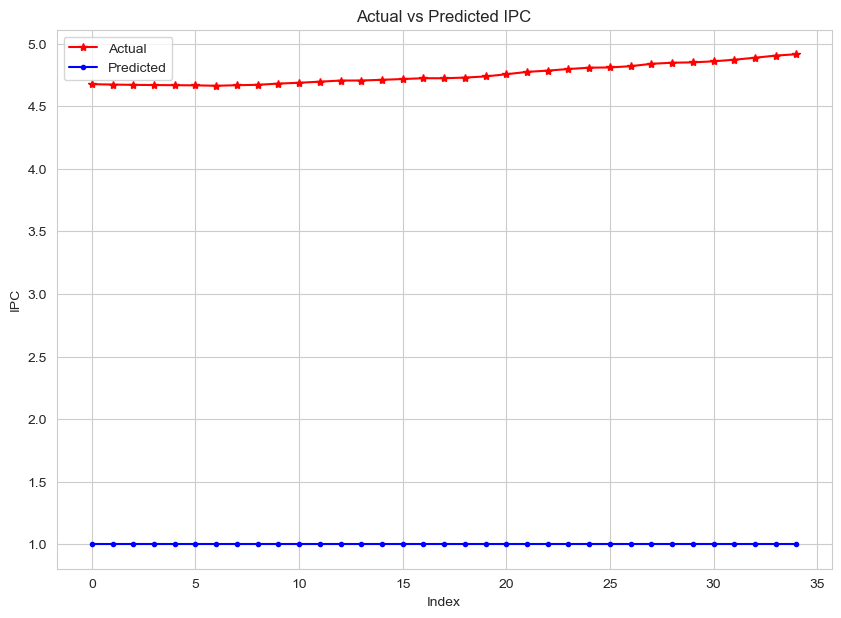

In [157]:
plt.figure(figsize=(10, 7))
plt.plot(range(yCon_val.size), yCon_val, linestyle='-', marker='*', color='r')
plt.plot(range(ypred.size), ypred, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted IPC')
plt.ylabel('IPC')
plt.xlabel('Index')

# Análisis de residuales

In [161]:
ypred_TRAIN=ts_model_full.predict(XCon_train_full)
ypred_TEST=ts_model_full.predict(XCon_test)

ypred_TRAIN=ypred_TRAIN[:,0]
ypred_TEST=ypred_TEST[:,0]
Redes=np.concatenate((ypred_TRAIN, ypred_TEST))

Real = np.concatenate((yCon_train_full,yCon_test))

d = {'Real': Real,  'Redes':Redes}
Todo=pd.DataFrame(data=d, index=Valores_datos.index[12:])
print(Todo)

1/1 [==============================] - 0s 22ms/step
                Real     Redes
Fecha                         
2010-01-31  4.248924  0.995847
2010-02-28  4.258587  0.996047
2010-03-31  4.259718  0.996303
2010-04-30  4.268018  0.996530
2010-05-31  4.267878  0.996912
...              ...       ...
2023-06-30  4.930654  1.000000
2023-07-31  4.935912  1.000000
2023-08-31  4.944068  1.000000
2023-09-30  4.950248  1.000000
2023-10-31  4.953147  1.000000

[166 rows x 2 columns]


In [162]:
difRedes=Todo['Redes']-Todo['Real']

Text(0.5, 0, 'Index')

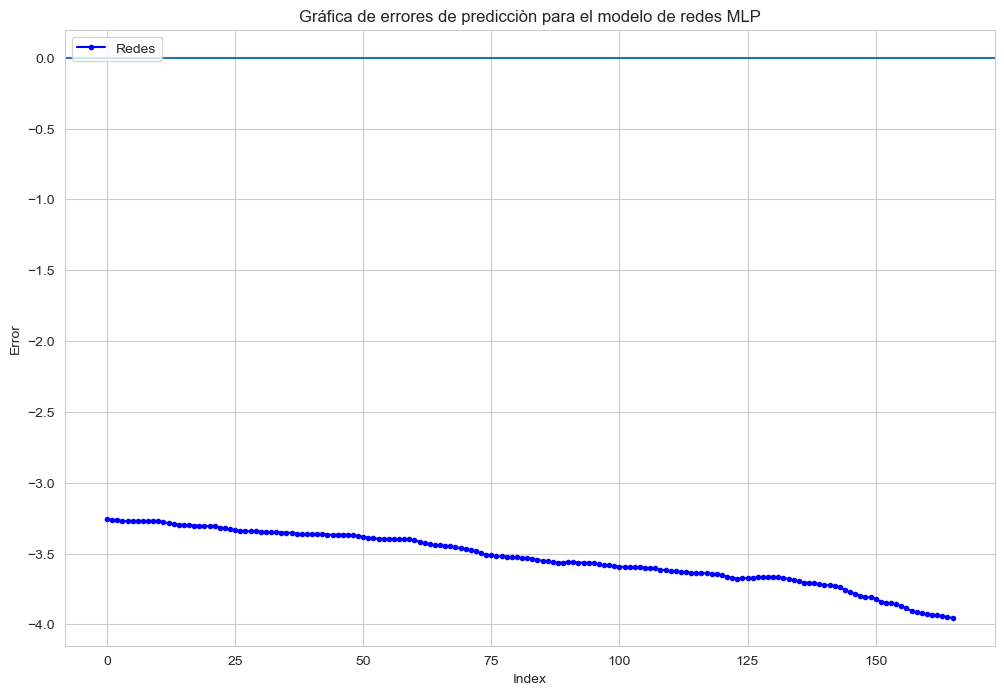

In [163]:
plt.figure(figsize=(12, 8))
plt.plot(range(difRedes.size), difRedes, linestyle='-', marker='.', color='b')
plt.axhline(y=0, linestyle='-')
plt.legend(['Redes'], loc=2)
plt.title('Gráfica de errores de predicciòn para el modelo de redes MLP')
plt.ylabel('Error')
plt.xlabel('Index')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16680\946787038.py:2: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  acf_red = plot_acf(difRedes,unbiased=False,lags=20,title='ACF Serie de Contaminación para Redes')


<Figure size 1000x600 with 0 Axes>

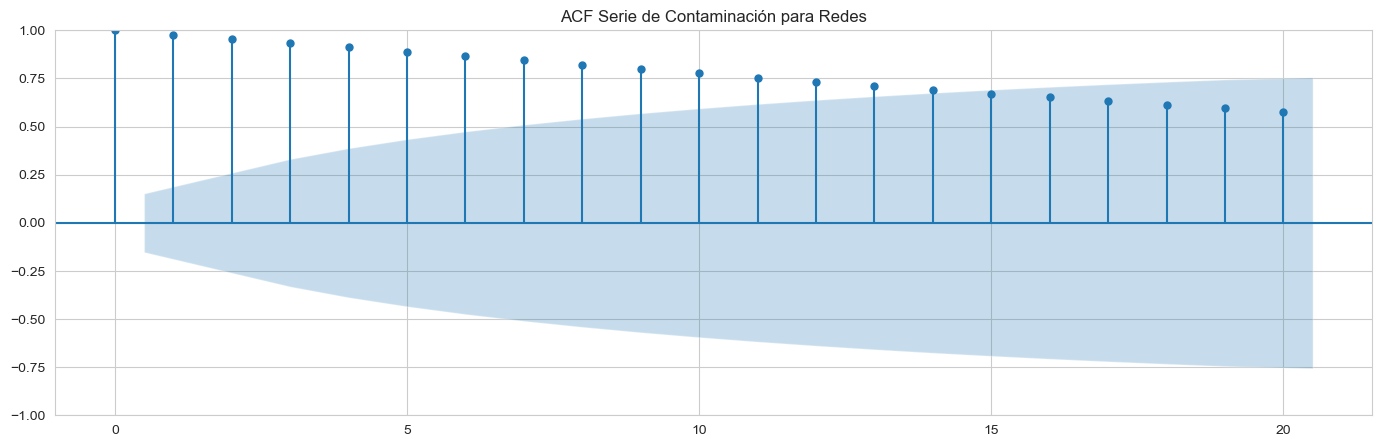

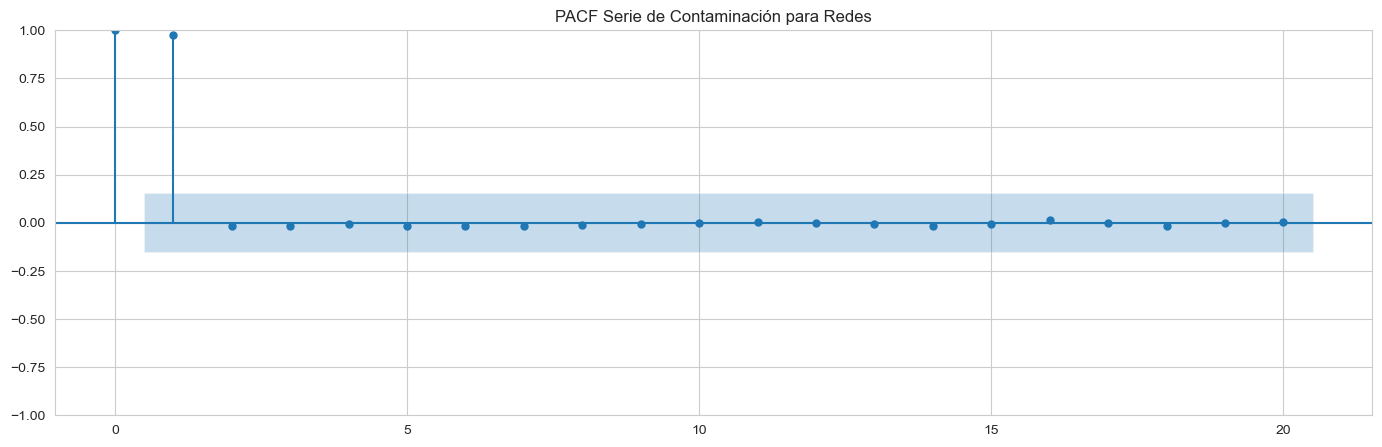

In [164]:
plt.figure(figsize=(10, 6))
acf_red = plot_acf(difRedes,unbiased=False,lags=20,title='ACF Serie de Contaminación para Redes')
plt.show(acf_red)
pacf_red = plot_pacf(difRedes,lags=20,title='PACF Serie de Contaminación para Redes')
plt.show(pacf_red)

Vemos en las gráficas que los residuales no oscilan al rededor de 0, además con el gráfico de ACF, quedan cosas por explciar.